# Das neuronale Netz täuschen

In [1]:
import numpy as np
import tensorflow as tf
import model_cnn
import preprocessing_classification as pre_c
import os, glob
import matplotlib.pyplot as plt
from scipy.stats import skew

In [2]:
def get_one_hot(n_dims, hot):
    tmp_arr = np.zeros([n_dims])
    tmp_arr[hot] = 1
    return tmp_arr

In [3]:
sess = tf.InteractiveSession()

text_length = 1000
num_authors = 5
input_cnn = tf.placeholder(tf.float32, [None, len(pre_c.alphabet), text_length, 1], name="input_x")
with tf.variable_scope("cnn"):
    cnn_logits, cnn_variables, _ = model_cnn.inference(
            input_x=input_cnn, keep_prob=1.0, num_authors=num_authors)
known_vars = []
known_vars = tf.global_variables()
saver = tf.train.Saver(var_list=known_vars)
saver.restore(sess, "../resources/1511967049/saves/cnn.ckpt-00009384")
print("cnn_classifier restored")

INFO:tensorflow:Restoring parameters from ../resources/1511967049/saves/cnn.ckpt-00009384
cnn_classifier restored


In [4]:
w_1 = sess.run('cnn/conv-1/W:0')
b_1 = sess.run('cnn/conv-1/b:0')
w_2 = sess.run('cnn/conv-2/W:0')
b_2 = sess.run('cnn/conv-2/b:0')
w_3 = sess.run('cnn/conv-3/W:0')
b_3 = sess.run('cnn/conv-3/b:0')
w_4 = sess.run('cnn/conv-4/W:0')
b_4 = sess.run('cnn/conv-4/b:0')
w_5 = sess.run('cnn/conv-5/W:0')
b_5 = sess.run('cnn/conv-5/b:0')
w_6 = sess.run('cnn/conv-6/W:0')
b_6 = sess.run('cnn/conv-6/b:0')
w_fc = sess.run('cnn/fc/W-fc:0')
b_fc = sess.run('cnn/fc/b-fc:0')
weights = [w_1, w_2, w_3, w_4, w_5, w_6, w_fc]
biases = [b_1, b_2, b_3, b_4, b_5, b_6, b_fc]

In [5]:
for wi,w in enumerate(weights):
    weights[wi] = np.squeeze(w)
weights[0] = np.transpose(weights[0], [1,0,2])

In [6]:
weights[-1] = np.reshape(weights[-1], [980,256,5])

In [7]:
biases = [np.zeros(4)] + biases

In [8]:
layers = [input_cnn.shape[1:3][::-1]] + [v.shape[-2:] for v in cnn_variables[:-1]] + [cnn_logits.shape[1:2]]

In [9]:
# RAM-sparende Implementierung

def get_NR_matrices(start = np.array([0.0,1.0,0.0,0.0,0.0]), startlayer = 0, numlayers=100):
    NR_matrices = []
    NR_matrices.append(start)
    if startlayer < 1:
        NR_matrices.append(np.sum(weights[-1]*NR_matrices[-1], axis=2))
        if numlayers < 3:
            return NR_matrices
    
    for i in range(2+startlayer,len(layers)):
        nr_pre = np.zeros([layers[-(i+1)][0], layers[-(i+1)][1]])
        ws = np.pad(weights[-i], ((0,int(layers[-(i+1)][0]-weights[-i].shape[0])),(0,0),(0,0)), mode='constant')
        print(ws.shape)
        for k in range(NR_matrices[-1].shape[0]):
            nr_pre = np.add(nr_pre, np.sum(np.multiply(np.roll(ws, shift=k, axis=0), NR_matrices[-1][k,:]), axis=2))
        NR_matrices.append(nr_pre)
        if numlayers == i+1-startlayer:
            return NR_matrices
    return NR_matrices

In [10]:
# NR_ms = []
# for i in range(5):
#     start = np.zeros(5)
#     start[i] = 1
#     NR_ms.append(get_NR_matrices(start))

In [11]:
# for i, NR_m in enumerate(NR_ms):
#     np.savez_compressed("../resources/NeuronRank/NeuronRank_five-authors-"+str(i), layer1=NR_m[0], layer2=NR_m[1], layer3=NR_m[2], layer4=NR_m[3], layer5=NR_m[4], layer6=NR_m[5], layer7=NR_m[6], layer8=NR_m[7])

In [12]:
NR_ms = [[],[],[],[],[]]
for file in glob.glob("../resources/NeuronRank/NeuronRank_five-authors*"):
    loaded = np.load(file)
    print(loaded.keys())
    for i in range(8):
        NR_ms[int(file[-5])].append(loaded["layer"+str(i+1)])

['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']


In [13]:
def run_txt(txt):
    # shorten text if it is too long
    if len(txt) > text_length:  # tf.flags.FLAGS.text_length:
        text_end_extracted = txt[0:text_length]
    else:
        text_end_extracted = txt
    # pad text with spaces if it is too short
    num_padding = text_length - len(text_end_extracted)
    padded = text_end_extracted + " " * num_padding
    text_int8_repr = np.array([pre_c.alphabet.find(char) for char in padded], dtype=np.int8)
    x_batch_one_hot = np.zeros(shape=[1, len(pre_c.alphabet), len(text_int8_repr), 1])
    for char_pos_in_seq, char_seq_char_ind in enumerate(text_int8_repr):
        if char_seq_char_ind != -1:
            x_batch_one_hot[0][char_seq_char_ind][char_pos_in_seq][0] = 1
    return sess.run(cnn_logits, feed_dict={input_cnn: x_batch_one_hot})

In [14]:
authors = ['Goethe', 'Kafka', 'Kleist', 'Raabe', 'Schiller']
all_real_texts = ['../resources/texts/'+ a.lower() +'.txt' for a in authors]
print('\n\n\n')
for author_i, text in enumerate(all_real_texts):
    with open(text, mode='r') as opentext:
        real_text = opentext.read(1000)
        real_auth = np.argmax(run_txt(real_text))
        while real_auth != author_i:
            real_text = opentext.read(1000)
            real_auth = np.argmax(run_txt(real_text))
        real_text_array = np.array([get_one_hot(hot=pre_c.alphabet.find(c), n_dims=len(pre_c.alphabet)) for c in real_text])
        indices_for_replacement = np.int16(np.argsort(NR_ms[3][-1]*real_text_array, axis=None)[-100:] / 70)[::-1]
        real_text_2 = (real_text + '.')[:-1]
        for i, r_i in enumerate(indices_for_replacement):
            real_text_2 = real_text_2[:r_i] + pre_c.alphabet[np.argmin(NR_ms[np.argmax(run_txt(real_text))][-1][r_i])] + real_text_2[r_i+1:]
            if np.argmax(run_txt(real_text_2)) != real_auth:
                print('--------------------')
                print(real_text)
                print("\nGeschrieben von " + authors[real_auth])
                print('--------------------')
                print(real_text_2)
                print("\nGeschrieben von " + authors[np.argmax(run_txt(real_text_2))])
                print("Ersetzte Zeichen: " + str(i+1))
                print('--------------------')
                print('\n\n\n')
                break





--------------------
imnisse endlich auch offenbaren kann.« »Wie!« rief der Major, »du hast auch Stufen und Grade deiner Verjüngungskunst? Du hast noch Geheimnisse für die Eingeweihten?« – »Ganz gewiß!« versetzte jener. »Das müßte gar eine schlechte Kunst sein, die sich auf einmal fassen ließe, deren Letztes von demjenigen gleich geschaut werden könnte, der zuerst hereintritt.« Man zauderte nicht lange, der Kammerdiener ward an den Major gewiesen, der ihn gut zu halten versprach. Die Baronin mußte Schächtelchen, Büchschen und Gläser hergeben, sie wußte nicht wozu; die Teilung ging vor sich, man war bis in die Nacht munter und geistreich zusammen. Bei dem späteren Aufgang des Mondes fuhr der Gast hinweg und versprach, in einiger Zeit zurückzukehren. Der Major kam ziemlich müde auf sein Zimmer. Er war früh aufgestanden, hatte sich den Tag nicht geschont und glaubte nunmehr das Bett bald zu erreichen. Allein er fand statt eines Dieners nunmehr zwei. Der alte Reitknecht zog ihn nach al

--------------------
, die mir durch den Kopf gingen, erhielten mich munter. Lange hört' ich ihn über meinem Schlafzimmer auf und nieder gehen; endlich überwältigte mich der Schlaf. Spät nach Mitternacht erweckte mich eine Stimme – eine Hand fuhr über mein Gesicht; wie ich aufsah, war es der Prinz, der, ein Licht in der Hand, vor meinem Bette stand. Er könne nicht einschlafen, sagte er und bat mich, ihm die Nacht verkürzen zu helfen. Ich wollte mich in meine Kleider werfen – er befahl mir zu bleiben, und setzte sich zu mir vor das Bette. »Es ist mir heute etwas vorgekommen,« fing er an, »davon der Eindruck aus meinem Gemüte nie mehr verlöschen wird. Ich ging von Ihnen, wie Sie wissen, in die ***kirche, worauf mich Civitella neugierig gemacht, und die schon von ferne meine Augen auf sich gezogen hatte. Weil weder Sie noch er mir gleich zur Hand waren, so machte ich die wenigen Schritte allein; Biondello ließ ich am Eingange auf mich warten. Die Kirche war ganz leer – eine schaurigkühle 

In [15]:
original_text = 'ungen zu spekulieren. Und im Notfall holst du dir jede beliebige Hülfe von der Gasse herauf, um vor möglichst vielen Zeugen und unter dem größtmöglichen Lärm deinen Willen durchzusetzen. Mein unglücklicher Zustand gestattet mir so selten, einen festen Entschluß zu fassen, aber es geht doch kaum ein Tag vorüber, an welchem du mich nicht zwingst, Zugeständnisse zu machen, die du sofort als kategorische Willensäußerungen meinerseits ausgibst. Paddenau ist mir verhaßt, und ich weiß kaum Worte dafür zu finden, wie verhaßt mir deine Mitwirkung an diesem albernen Feste erscheint.« »Aber lieber, guter Papa, du hast doch aus freien Stücken dem Rektor meine Hülfeleistung angeboten. Er hatte noch nicht gewagt, dich darum zu bitten.« »Habe ich das?« winselte der Hofrat. »Es ist möglich, ich will sogar sagen, daß es so ist; allein damals schwebte die Sache noch in weiter Ferne, und meine unglückliche Phantasie ging leider Gottes wieder einmal einem Ziel, welches ich mir ganz anders vorstellte, in S'
fooling_text = 'ungen zu spekulieren. Und im Notfall holst du dir jede beliebige Hülfe von der Gasse herauf, um vor möglichst vielen Zeugen und unter dem größtmöglichen Lärm deinen Willen durchzusetzen. Mein unglücklicher Zustand gestattet mir so selten, einen festen Entschluß zu fassen, aber es geht doch kaum ein Tag vorüber, an welchem du mich nicht zwingst, Zugeständnisse zu machen, die du sofort als kategorische Willensäußerungen meinerseits ausgibst. Paddenau ist mir verhaßt, und ich weiß kaum Worte .afür zu finden, wie verhaßt mir deine Mitwirkung an diesem albernen Feste erscheint.« »Aber lieber, guter Papa, du hast doch aus freien Stücken dem Rektor meine Hülfeleistung angeboten. Er hatte noch nicht gewagt, dich darum zu bitten.« »Habe ich das?« winselte der Hofrat. »Es ist möglich, ich will sogar sagen, daß es so ist; allein damals schwebte die Sache noch in weiter Ferne, und meine unglückliche Phantasie ging leider Gottes wieder einmal einem Ziel, welches ich mir ganz anders vorstellte, in S'

In [16]:
def run_txt_for_activations(txt):
    # shorten text if it is too long
    if len(txt) > text_length:  # tf.flags.FLAGS.text_length:
        text_end_extracted = txt[0:text_length]
    else:
        text_end_extracted = txt
    # pad text with spaces if it is too short
    num_padding = text_length - len(text_end_extracted)
    padded = text_end_extracted + " " * num_padding
    text_int8_repr = np.array([pre_c.alphabet.find(char) for char in padded], dtype=np.int8)
    x_batch_one_hot = np.zeros(shape=[1, len(pre_c.alphabet), len(text_int8_repr), 1])
    for char_pos_in_seq, char_seq_char_ind in enumerate(text_int8_repr):
        if char_seq_char_ind != -1:
            x_batch_one_hot[0][char_seq_char_ind][char_pos_in_seq][0] = 1
    return sess.run([cnn_variables, cnn_logits], feed_dict={input_cnn: x_batch_one_hot})

In [17]:
original_activations = run_txt_for_activations(original_text)
fooling_activations = run_txt_for_activations(fooling_text)

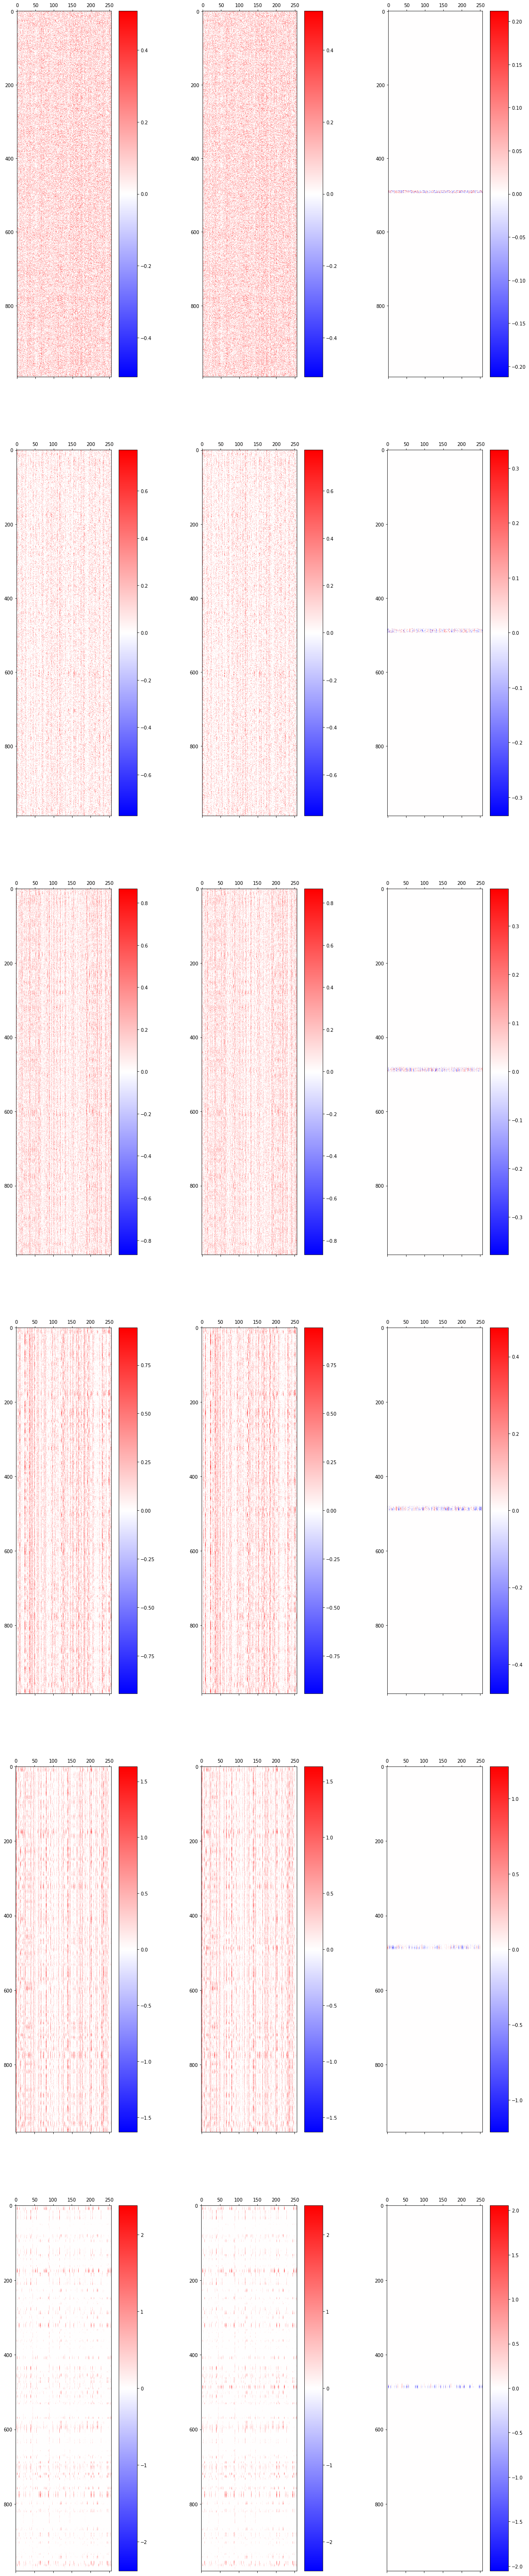

In [18]:
plt.close('all')
fig = plt.figure(figsize = [20,100])
fig_ctr = 1
for o_a, f_a in zip(original_activations[0][:-1], fooling_activations[0][:-1]):
    ax = fig.add_subplot(6,3,fig_ctr)
    o_a_plot = np.squeeze(o_a)
    o_a_ax = ax.matshow(o_a_plot, cmap='bwr', vmin=-np.max(np.abs(o_a_plot)), vmax=np.max(np.abs(o_a_plot)))
    plt.colorbar(o_a_ax)
    fig_ctr += 1
    ax = fig.add_subplot(6,3,fig_ctr)
    f_a_plot = np.squeeze(f_a)
    f_a_ax = ax.matshow(f_a_plot, cmap='bwr', vmin=-np.max(np.abs(f_a_plot)), vmax=np.max(np.abs(f_a_plot)))
    plt.colorbar(f_a_ax)
    fig_ctr += 1
    ax = fig.add_subplot(6,3,fig_ctr)
    diff_plot = np.squeeze(o_a)-np.squeeze(f_a)
    diff_ax = ax.matshow(diff_plot, cmap='bwr', vmin=-np.max(np.abs(diff_plot)), vmax=np.max(np.abs(diff_plot)))
    plt.colorbar(diff_ax)
    fig_ctr += 1
plt.show()